Parts of notebook are taken from SBI tutorials and Peter Melchior's LFI introduction.

## Recap

We would like to perform inference on model's parameters $\theta$ given observations $\{x\}_i$:
$$ P(\theta | \{x\}_i)$$

We do this with Bayes rule:
$$ P(\theta | \{x\}_i) \propto P(\{x\}_i|\theta) P(\theta),$$
which relies on the Likelihood function $P(\{x\}_i|\theta)$. 

<br>
However, what if we don't know the Likelihood?
<br>
<br>

Well say we have a simulator. Then we can simulate enough examples such that we can measure the frequency of examples reproducing the data (or getting close to it). This is called Approximate Bayesian Computation, or ABC:

![ABC](https://upload.wikimedia.org/wikipedia/commons/b/b9/Approximate_Bayesian_computation_conceptual_overview.svg)

But, what if the simulation is very expensive, and the data is high dimensional? Then we would need to run far too many simulations. E.g., images of a galaxy - we can't simply simulate enough galaxies until the pixels match up!

So we turn to Likelihood-Free Inference. Instead of needing to call the simulation over and over, we instead run it only a few times, and fit a function:

$$P(\theta|x)$$

for several examples of $\{\theta, x\}_i$, such that $\sum_i P(\theta|x)$ is maximized.

# PyTorch quick start

In [1]:
import torch
import numpy as np

PyTorch is like numpy in syntax, but adds: vectorization, GPU-acceleration, and autodifferentiation. It also has deep learning kits. Let's do some linear algebra:

Instead of `np.array`, we use `torch.tensor`:

In [2]:
np.array([5., 3.]), torch.tensor([5., 3.])

(array([5., 3.]), tensor([5., 3.]))

But we can pass data back and forth between numpy and torch like so:

In [3]:
x = np.array([10., 5., 1.])
y = torch.tensor(x)
z = np.array(y)
x, y, z

(array([10.,  5.,  1.]),
 tensor([10.,  5.,  1.], dtype=torch.float64),
 array([10.,  5.,  1.]))

Create a vector of 10 zeros:

In [4]:
x = torch.zeros(10)
x

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Add 1 to each element:

In [5]:
x + 1

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Generate random numbers:

In [6]:
x = torch.randn(10)
x

tensor([-1.2177,  0.0391,  1.3016,  0.7003,  1.0195, -0.2013,  0.4223, -0.8245,
        -1.0312,  1.5593])

Do some basic operations, all with numpy syntax:

In [7]:
torch.cos(x), torch.log(torch.abs(x) + 1), torch.sum(x), x.std()

(tensor([0.3458, 0.9992, 0.2660, 0.7647, 0.5238, 0.9798, 0.9122, 0.6789, 0.5138,
         0.0115]),
 tensor([0.7965, 0.0383, 0.8336, 0.5308, 0.7028, 0.1834, 0.3522, 0.6013, 0.7086,
         0.9397]),
 tensor(1.7673),
 tensor(0.9882))

Now, let's do stuff on the GPU:

In [8]:
x = torch.randn((100, 100))

#Move to GPU:
x = x.cuda()
x

tensor([[-1.5473, -1.4541, -0.4094,  ..., -0.9467, -0.3957, -0.9190],
        [ 1.2915,  0.3078,  1.3502,  ..., -0.2240,  1.4586, -1.1972],
        [ 0.7421, -1.2721,  0.3409,  ..., -0.6925,  1.2249, -0.8580],
        ...,
        [-0.6698,  1.7907, -1.3751,  ...,  0.6343, -0.2695,  0.5030],
        [-0.1271,  1.6968, -1.8079,  ..., -0.1754, -1.8075, -0.9347],
        [-1.1590, -0.4660,  0.1615,  ...,  0.3799,  0.2057, -1.4509]],
       device='cuda:0')

So the vector is on the GPU. We can do vector operations all on the GPU now:

In [9]:
y = x**3 + torch.cos(x) - x.mean()
y

tensor([[-3.6822, -2.9593,  0.8478,  ..., -0.2651,  0.8598, -0.1704],
        [ 2.4289,  0.9812,  2.6792,  ...,  0.9628,  3.2140, -1.3521],
        [ 1.1448, -1.7652,  0.9811,  ...,  0.4366,  2.1759,  0.0214],
        ...,
        [ 0.4825,  5.5231, -2.4069,  ...,  1.0597,  0.9434,  1.0024],
        [ 0.9889,  4.7585, -6.1445,  ...,  0.9783, -6.1405, -0.2235],
        [-1.1578,  0.7912,  0.9902,  ...,  0.9826,  0.9866, -2.9355]],
       device='cuda:0')

And move back to the CPU like so:

In [10]:
z = y.cpu()
z

tensor([[-3.6822, -2.9593,  0.8478,  ..., -0.2651,  0.8598, -0.1704],
        [ 2.4289,  0.9812,  2.6792,  ...,  0.9628,  3.2140, -1.3521],
        [ 1.1448, -1.7652,  0.9811,  ...,  0.4366,  2.1759,  0.0214],
        ...,
        [ 0.4825,  5.5231, -2.4069,  ...,  1.0597,  0.9434,  1.0024],
        [ 0.9889,  4.7585, -6.1445,  ...,  0.9783, -6.1405, -0.2235],
        [-1.1578,  0.7912,  0.9902,  ...,  0.9826,  0.9866, -2.9355]])

PyTorch also lets you do autodifferentiation, which is a big part of deep learning. Let's look at the gradient of $\sum_i \cos(x_i)^2$:

In [11]:
def my_func(x):
    return (torch.cos(x)**2).sum()

First, we make our variable know that it should record gradients as it is operated upon with the `requires_grad` flag:

In [12]:
x = torch.tensor([np.pi/4, np.pi/8])
x.requires_grad = True

Now, we take the gradient at each of $x=({\pi \over 4}, {\pi \over 8})$, which is -2 \cos(x) \sin(x):

In [13]:
torch.autograd.grad(my_func(x), x)

(tensor([-1.0000, -0.7071]),)

We can also do this all on the GPU! We can also do higher-order derivatives by repeatedly calling grad.

In [14]:
y = x.cuda()
torch.autograd.grad(my_func(y), y)

(tensor([-1.0000, -0.7071], device='cuda:0'),)

With gradient information, one can do gradient descent operation on a model using `torch.optim.SGD`:

In [15]:
torch.optim.SGD;

One can write a class that inherits from `torch.nn.Module`, declares `torch.nn.Parameters(...)` around its parameters, and then `torch.optim.SGD` can optimize those. This is how all deep learning works: gradient-based optimization of some highly-flexible differentiable model.

PyTorch is used as the backend for SBI. Let's move on to that now.

# Likelihood-free Inference Tutorial:

Say that there is the following *true* model---a 2D Gaussian with known width:

$$(x_1, x_2) \sim \mathcal{N}(\mu, \Sigma=0.25 I)$$

The true vector for the Gaussian is $\mu = (3, -1.5)$, which we are unaware of. We make 5 observations and attempt to reconstruct a posterior over $\mu$.

The likelihood of this model is given by $$P(x|\mu) \sim \exp\left({(x_1-3)^2 + (x_2- (-1.5))^2\over 2 \cdot 0.25}\right),$$
which gives us a way to recover the parameter given data and a prior: $P(\mu|x) \sim P(x|\mu) P(\mu)$.


But now, say that **we don't know this likelihood**. Pretend we are not given the likelihood of a Gaussian. We only know how to draw samples from a Gaussian: this is our "simulation."

#### How can we compute a distribution over $\mu$, without a likelihood?

## Likelihood-free Inference

For LFI, you need to provide two ingredients:

1. a prior distribution that allows to sample parameter sets (your guess at $\mu$)
2. a simulator that takes parameter sets and produces simulation outputs (samples of a Gaussian with a given $\mu$)

For example, let's pretend we have a reasonable idea that $\mu$ is within $[-10, 10]$ with uniform probability. We also have our simulator that generates samples of a Gaussian.

## Running the inference procedure

`sbi` provides a simple interface to run state-of-the-art algorithms for simulation-based inference.

# Getting started with `sbi`

In [16]:
import torch
import sbi.utils as utils
from sbi.inference.base import infer

Let's write out our uniform prior:

In [22]:
prior = utils.BoxUniform(
    low=torch.tensor([-10., -10.]),
    high=torch.tensor([10., 10.])
)


This will be used to generate proposals for $\mu$.

Now, let's write out our simulator for a given $\mu$:

In [23]:
def simulator(mu):
    # Generate samples from N(mu, sigma=0.5)
    
    return mu + 0.5 * torch.randn_like(mu)

Let's test it by inputting a vector of potential $\mu$ values:

In [24]:
simulator(
    torch.tensor([[1, 8.], [3., 5.], [-7., -3.]])
)

tensor([[ 0.7272,  6.8405],
        [ 3.4974,  5.2752],
        [-7.7825, -2.4473]])

So here are samples of each simulation. Now, we will use this simulator with Likelihood-Free Inference to construct a distribution over potential mu values:

#### Step 1: Let's learn a likelihood from the simulator:

The likelihood is a type of "normalized" Neural Network---called a "normalizing flow". (as an example check out my paper where we learn an accurate CMD straight from Gaia data with a normalizing flow: https://arxiv.org/abs/1908.08045)

In [25]:
prior

BoxUniform(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1)

This will be a bit slow because we are training the neural network on a CPU:

In [82]:
posterior = infer(
    simulator,
    prior,
#     method='SNPE',
    method='SNLE',
    num_workers=-1,
    num_simulations=1000)


Neural network successfully converged after 91 epochs.


Now we have a neural network that acts as our likelihood! Next, let's record our "observations" of the true distribution:

In [83]:
n_observations = 10
observation = torch.tensor([3., -1.5])[None] + 0.5*torch.randn(n_observations, 2)

In [84]:
import seaborn as sns
from matplotlib import pyplot as plt

Here's the data:

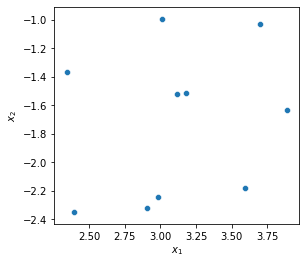

In [85]:
sns.scatterplot(x=observation[:, 0], y=observation[:, 1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.axis('scaled')
plt.show()

We can now use our learned likelihood (a neural network) to do inference on $\mu$! The way the problem is structured on the neural net side, we need to manually include all observations separately. But we can make samples of a single datapoint like so:

In [ ]:
samples = posterior.sample((10000,), x=observation[0])

Generating samples:  35%|███▍      | 3460/10000 [16:09<30:28,  3.58it/s]

And then plot this (it should look approximately Gaussian):

In [ ]:

log_probability = posterior.log_prob(samples, x=observation[0])
out = utils.pairplot(samples, limits=[[-10,10],[-10,10]], fig_size=(6,6))


Let's create a grid of $\mu$ close to the expected value of $(3, -15)$, and calculate the total log likelihood for each value:

In [ ]:
import numpy as np

bounds = [3-1, 3+1, -1.5-1, -1.5+1]

mu_1, mu_2 = torch.tensor(np.mgrid[bounds[0]:bounds[1]:2/50., bounds[2]:bounds[3]:2/50.]).float()

samples = torch.cat(
    (mu_1.reshape(-1, 1), mu_2.reshape(-1, 1)),
    dim=1
)


In [ ]:
log_prob = sum([posterior.log_prob(samples, x=observation[i]) for i in range(len(observation))])
prob = torch.exp(log_prob)
plt.contourf(prob.reshape(*mu_1.shape), extent=bounds, origin='lower')
plt.axis('scaled')

Now, this was a simple example and we could have written out an explicit likelihood. But the real power of Likelihood-Free Inference comes for high dimensional and complicated distributions, when there is no explicit analytic likelihood available. The exact same algorithm as above can simply be scaled up to a higher dimensional space.

Let's compare to the true likelihood:

In [ ]:
true_like = lambda x: -((x[0] - mu_1)**2 + (x[1] - mu_2)**2)/(2*0.5**2)
log_prob = sum([true_like(observation[i]) for i in range(len(observation))])
prob = torch.exp(log_prob)
plt.contourf(prob, extent=bounds, origin='lower')
plt.axis('scaled')

Not bad considering we only used O(1000) examples to learn the likelihood! The more simulations you use (much faster to train with GPUs), the more accurate the likelihood will be.

## Emphasis:

LFI is a very general approach that will eventually be used everywhere in astrophysics where we don't have clear  likelihoods. To help give examples of what it could do:

- Photo-z: parameter is z, you then generate some SEDs - that is your "simulator". Then use `sbi` to compare to data. You get a posterior over z.
- Galaxy images: parameters are galaxy properties, orientation, distance, you then simulate some images of galaxies. You then use `sbi` to infer the galaxy properties.
    - Here, one would probably want to use an autoencoder to first compress the images to vectors describing the properties.
    - The likelihood is then learned over that autoencoded vector.
- Cosmological parameters from a density field, simulate some power spectrum and feed into `sbi`. 
    - To avoid parts of the simulation you know are bad (e.g., small scales), simply add noise to them so the neural net doesn't use them.
    - Again, here one would need to create summary statistics using another model.

## Requirements for the simulator, prior, and observation

Regardless of the algorithm you need to provide a prior and a simulator for training. Let's talk about what requirements they need to satisfy.


### Prior
A prior is a distribution object that allows to sample parameter sets. Any class for the prior is allowed as long as it allows to call `prior.sample()` and `prior.log_prob()`.

### Simulator
The simulator is a Python callable that takes in a parameter set and outputs data with some (even if very small) stochasticity.

Allowed data types and shapes for input and output:

- the input parameter set and the output have to be either a `np.ndarray` or a `torch.Tensor`. 
- the input parameter set should have either shape `(1,N)` or `(N)`, and the output must have shape `(1,M)` or `(M)`.

You can call simulators not written in Python as long as you wrap them in a Python function.

### Observation
Once you have a trained posterior, you will want to evaluate or sample the posterior $p(\theta|x_o)$ at certain observed values $x_o$:

- The allowable data types are either Numpy `np.ndarray` or a torch `torch.Tensor`.
- The shape must be either `(1,M)` or just `(M)`.

## Running different algorithms

`sbi` implements three classes of algorithms that can be used to obtain the posterior distribution: SNPE, SNLE, and SNRE. You can try the different algorithms by simply swapping out the `method`:

In [ ]:
posterior = infer(simulator, prior, method='SNPE', num_simulations=1000)
posterior = infer(simulator, prior, method='SNLE', num_simulations=1000)
posterior = infer(simulator, prior, method='SNRE', num_simulations=1000)

You can then infer, sample, evaluate, and plot the posterior as described above.